# Sale probability prediction model based in Tensorflow optimized for Mac M1 chip

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import defaultdict

In [2]:
def displayDataFrame(df_to_display, all_frame=False):
    if all_frame:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(df_to_display)
    else:
        display(df_to_display)

In [51]:
# read data
area_codes_df = pd.read_excel('areacodes.xlsx', 
                            header=None)
displayDataFrame(area_codes_df, all_frame=False)

leads_df = pd.read_csv('all_calls_2021.csv', 
                    parse_dates=['callDate','callStartTime'])
displayDataFrame(leads_df, all_frame=False)

leads_source_map = pd.read_csv('inhousesources.csv')
displayDataFrame(leads_source_map, all_frame=False)

leads_source_map2 = pd.read_csv('othersources.csv')
displayDataFrame(leads_source_map, all_frame=False)

0
0    201 NJ
1    202 DC
2    203 CT
3    204 MB
4    205 AL
..      ...
345  979 TX
346  980 NC
347  984 NC
348  985 LA
349  989 MI

[350 rows x 1 columns]

isSale       callStartTime  tenure agentId supervisorId site  \
0             0 2021-08-11 18:01:09     6.0     02T          0JO  NIC   
1             0 2021-08-11 11:24:33    10.0    NM01          YM2  NIC   
2             0 2021-08-11 10:12:41    61.0     GWF          AB1  BKV   
3             0 2021-08-11 14:31:44    83.0     9TW          0L7  CLW   
4             1 2021-08-11 11:50:43    25.0     I18          ME1  NBF   
...         ...                 ...     ...     ...          ...  ...   
1710838       0 2021-08-11 12:03:48     5.0     0BA          02G  PHX   
1710839       0 2021-08-11 11:50:42    23.0     K03          SF1  CLW   
1710840       0 2021-08-11 12:04:58     5.0     0AK          0EJ  PHX   
1710841       0 2021-08-11 11:55:30    13.0     P35          HF1  NBF   
1710842       0 2021-08-11 11:49:33    13.0     P40         MC01  BKV   

        shiftStartTime  atOffice areaCode   callDate        DNIS  
0             10:00 AM         1      850 2021-03-12  8773367219  
1             10:00 AM         1      570 2021-01-15  8773367219  
2             09:45 AM         0      816 2021-02-23  8558887732  
3             09:45 AM         0      919 2021-05-13  7273258284  
4             07:45 AM         0      682 2021-02-08  8552458994  
...                ...       ...      ...        ...         ...  
1710838       07:45 AM         0      786 2021-08-11  7273060365  
1710839       07:45 AM         0      803 2021-08-11  7273060365  
1710840       09:45 AM         0      509 2021-08-11  7277560151  
1710841       09:45 AM         0      302 2021-08-11  8558046073  
1710842       07:45 AM         0      609 2021-08-11  8668260579  

[1710843 rows x 11 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

In [52]:
leads_df = leads_df.sample(5000)

In [53]:
osr3s = {}
for index, row in leads_source_map.iterrows():
    osr3s[row['DNIS']] = row['Source']

for index, row in leads_source_map2.iterrows():
    osr3s[row['DNIS']] = row['Source']

In [54]:
# add osr3 column to leads df using DNIS
leads_df['osr3'] = leads_df['DNIS'].map(osr3s).fillna(leads_df['DNIS'])

In [55]:
# build area code dictionary
area_codes = {}
for r in area_codes_df[0]:
    area_codes[r.split()[0]] = r.split()[1]

In [56]:
# add state column to leads df using areacode
leads_df['state'] = leads_df['areaCode'].map(area_codes).fillna('NA')
# print(leads)

In [57]:
leads_df['dayOfWeek'] = leads_df['callDate'].dt.day_name()

In [58]:
def get_medicare_season(date):
    AEPStart = datetime.datetime.strptime("15-10-2020", "%d-%m-%Y").replace(year=date.year)
    AEPEnd = datetime.datetime.strptime("07-12-2020", "%d-%m-%Y").replace(year=date.year)
    OEPStart = datetime.datetime.strptime("01-01-2020", "%d-%m-%Y").replace(year=date.year)
    OEPEnd = datetime.datetime.strptime("31-03-2020", "%d-%m-%Y").replace(year=date.year)
    if AEPStart <= date <= AEPEnd:
        return 'AEP'
    elif OEPStart <= date <= OEPEnd:
        return 'OEP'
    else:
        return 'ROY'

In [59]:

# convert time to seconds of day
def get_seconds_of_day(timestamp):
    midnight = datetime.date(
        timestamp.year, timestamp.month, timestamp.day)
    return int(timestamp.strftime('%s')) - int(midnight.strftime('%s'))

In [60]:
# add medicare season column using callDate
leads_df['medicareSeason'] = leads_df['callDate'].apply(
                        lambda x: get_medicare_season(x))


# add seconds of day using callStartTime
leads_df['callStartTime'] = leads_df['callStartTime'].apply(
                        lambda x: get_seconds_of_day(x))

displayDataFrame(leads_df)

isSale  callStartTime  tenure agentId supervisorId site  \
1690308       0          43939    31.0     F22          HF1  NBF   
422827        0          52803     8.0     R30          MB1  LAV   
1069189       0          31257    11.0     N96          NaN  CLW   
195918        0          58972     7.0     Q66          MB1  LAV   
832511        0          31285    24.0     J37          GZ8  CLW   
...         ...            ...     ...     ...          ...  ...   
1256609       0          31154    23.0     J63          MA1  FLL   
932146        0          36338    14.0     O86          AD2  FLL   
1371325       0          43078     6.0     02V          YM2  NIC   
625350        0          39460     8.0     R34          RM1  BKV   
1169482       0          47056     5.0     0DV          AD2  FLL   

        shiftStartTime  atOffice areaCode   callDate        DNIS        osr3  \
1690308       07:45 AM         0      337 2021-08-04  8552144394          IB   
422827        03:00 PM         0      757 2021-02-09  8558201719          IB   
1069189       07:45 AM         0      910 2021-04-27  7273320768         ID2   
195918        09:45 AM         0      904 2021-01-25  8773844114          IB   
832511        07:45 AM         0      347 2021-04-21     7726474     7726474   
...                ...       ...      ...        ...         ...         ...   
1256609       07:45 AM         0      269 2021-06-09  8553320982          IB   
932146        09:45 AM         0      303 2021-04-08     7726474     7726474   
1371325       11:30 AM         1      970 2021-07-21  9702892355  9702892355   
625350        09:45 AM         0      502 2021-03-18  8558201722          IB   
1169482       09:45 AM         0      540 2021-05-25  7273320765         US5   

        state  dayOfWeek medicareSeason  
1690308    LA  Wednesday            ROY  
422827     VA    Tuesday            OEP  
1069189    NC    Tuesday            ROY  
195918     FL     Monday            OEP  
832511     NY  Wednesday            ROY  
...       ...        ...            ...  
1256609    MI  Wednesday            ROY  
932146     CO   Thursday            ROY  
1371325    CO  Wednesday            ROY  
625350     KY   Thursday            OEP  
1169482    VA    Tuesday            ROY  

[5000 rows x 15 columns]

In [61]:
leads_df.drop(columns=['callDate', 'DNIS'], inplace=True)

In [62]:
def change_sales_number(sales):
    return 0 if sales == 0 else 1
leads_df['isSale'] = leads_df['isSale'].apply(lambda x:change_sales_number(x))

<AxesSubplot:xlabel='isSale', ylabel='count'>

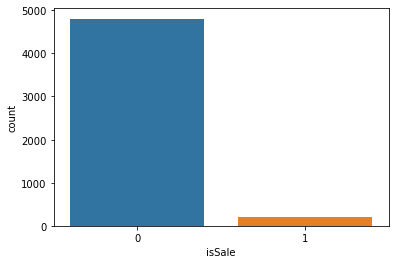

In [63]:
# visualize data
sns.countplot(x = 'isSale', data=leads_df)

In [64]:
 leads_df.columns

Index(['isSale', 'callStartTime', 'tenure', 'agentId', 'supervisorId', 'site',
       'shiftStartTime', 'atOffice', 'areaCode', 'osr3', 'state', 'dayOfWeek',
       'medicareSeason'],
      dtype='object')

In [65]:
leads_df['areaCode'] = leads_df['areaCode'].astype(str)
leads_df['osr3'] = leads_df['osr3'].astype(str)

In [66]:
displayDataFrame(leads_df)

isSale  callStartTime  tenure agentId supervisorId site  \
1690308       0          43939    31.0     F22          HF1  NBF   
422827        0          52803     8.0     R30          MB1  LAV   
1069189       0          31257    11.0     N96          NaN  CLW   
195918        0          58972     7.0     Q66          MB1  LAV   
832511        0          31285    24.0     J37          GZ8  CLW   
...         ...            ...     ...     ...          ...  ...   
1256609       0          31154    23.0     J63          MA1  FLL   
932146        0          36338    14.0     O86          AD2  FLL   
1371325       0          43078     6.0     02V          YM2  NIC   
625350        0          39460     8.0     R34          RM1  BKV   
1169482       0          47056     5.0     0DV          AD2  FLL   

        shiftStartTime  atOffice areaCode        osr3 state  dayOfWeek  \
1690308       07:45 AM         0      337          IB    LA  Wednesday   
422827        03:00 PM         0      757          IB    VA    Tuesday   
1069189       07:45 AM         0      910         ID2    NC    Tuesday   
195918        09:45 AM         0      904          IB    FL     Monday   
832511        07:45 AM         0      347     7726474    NY  Wednesday   
...                ...       ...      ...         ...   ...        ...   
1256609       07:45 AM         0      269          IB    MI  Wednesday   
932146        09:45 AM         0      303     7726474    CO   Thursday   
1371325       11:30 AM         1      970  9702892355    CO  Wednesday   
625350        09:45 AM         0      502          IB    KY   Thursday   
1169482       09:45 AM         0      540         US5    VA    Tuesday   

        medicareSeason  
1690308            ROY  
422827             OEP  
1069189            ROY  
195918             OEP  
832511             ROY  
...                ...  
1256609            ROY  
932146             ROY  
1371325            ROY  
625350             OEP  
1169482            ROY  

[5000 rows x 13 columns]

In [79]:
categorical_cols = ['agentId', 'areaCode','site','supervisorId','shiftStartTime', 'state', 'dayOfWeek', 'medicareSeason', 'osr3']

from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
# leads_df[categorical_cols] = leads_df[categorical_cols].apply(lambda col: le.fit_transform(col))    
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder = encoder.fit(leads_df[categorical_cols])
tmp_ohe_data = pd.DataFrame(
        encoder.transform(leads_df[categorical_cols]).toarray(),
        columns=encoder.get_feature_names(categorical_cols),
    )
#One-hot-encode the categorical columns.
#Unfortunately outputs an array instead of dataframe.
# array_hot_encoded = ohe.fit_transform(leads_df[categorical_cols])
# print(array_hot_encoded)
# #Convert it to df
# data_hot_encoded = pd.DataFrame(array_hot_encoded, index=leads_df.index)

# #Extract only the columns that didnt need to be encoded
# data_other_cols = leads_df.drop(columns=categorical_cols)
temp1 = leads_df.drop(columns=categorical_cols)
test1 = temp1.reset_index(drop=True)
displayDataFrame(test1)
# #Concatenate the two dataframes : 
displayDataFrame(tmp_ohe_data)
test = test1.join(tmp_ohe_data)
displayDataFrame(test)


isSale  callStartTime  tenure  atOffice
0          0          43939    31.0         0
1          0          52803     8.0         0
2          0          31257    11.0         0
3          0          58972     7.0         0
4          0          31285    24.0         0
...      ...            ...     ...       ...
4995       0          31154    23.0         0
4996       0          36338    14.0         0
4997       0          43078     6.0         1
4998       0          39460     8.0         0
4999       0          47056     5.0         0

[5000 rows x 4 columns]

agentId_00A  agentId_00B  agentId_00C  agentId_00D  agentId_00E  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          0.0          0.0          0.0          0.0   
2             0.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
4995          0.0          0.0          0.0          0.0          0.0   
4996          0.0          0.0          0.0          0.0          0.0   
4997          0.0          0.0          0.0          0.0          0.0   
4998          0.0          0.0          0.0          0.0          0.0   
4999          0.0          0.0          0.0          0.0          0.0   

      agentId_00G  agentId_00H  agentId_00I  agentId_00J  agentId_00N  ...  \
0             0.0          0.0          0.0          0.0          0.0  ...   
1             0.0          0.0          0.0          0.0          0.0  ...   
2             0.0          0.0          0.0          0.0          0.0  ...   
3             0.0          0.0          0.0          0.0          0.0  ...   
4             0.0          0.0          0.0          0.0          0.0  ...   
...           ...          ...          ...          ...          ...  ...   
4995          0.0          0.0          0.0          0.0          0.0  ...   
4996          0.0          0.0          0.0          0.0          0.0  ...   
4997          0.0          0.0          0.0          0.0          0.0  ...   
4998          0.0          0.0          0.0          0.0          0.0  ...   
4999          0.0          0.0          0.0          0.0          0.0  ...   

      osr3_RS2  osr3_TL1  osr3_TL2  osr3_UP2  osr3_US2  osr3_US3  osr3_US4  \
0          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
4995       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4996       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4997       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4998       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4999       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      osr3_US5  osr3_WEB  osr3_Web  
0          0.0       0.0       0.0  
1          0.0       0.0       0.0  
2          0.0       0.0       0.0  
3          0.0       0.0       0.0  
4          0.0       0.0       0.0  
...        ...       ...       ...  
4995       0.0       0.0       0.0  
4996       0.0       0.0       0.0  
4997       0.0       0.0       0.0  
4998       0.0       0.0       0.0  
4999       1.0       0.0       0.0  

[5000 rows x 2077 columns]

isSale  callStartTime  tenure  atOffice  agentId_00A  agentId_00B  \
0          0          43939    31.0         0          0.0          0.0   
1          0          52803     8.0         0          0.0          0.0   
2          0          31257    11.0         0          0.0          0.0   
3          0          58972     7.0         0          0.0          0.0   
4          0          31285    24.0         0          0.0          0.0   
...      ...            ...     ...       ...          ...          ...   
4995       0          31154    23.0         0          0.0          0.0   
4996       0          36338    14.0         0          0.0          0.0   
4997       0          43078     6.0         1          0.0          0.0   
4998       0          39460     8.0         0          0.0          0.0   
4999       0          47056     5.0         0          0.0          0.0   

      agentId_00C  agentId_00D  agentId_00E  agentId_00G  ...  osr3_RS2  \
0             0.0          0.0          0.0          0.0  ...       0.0   
1             0.0          0.0          0.0          0.0  ...       0.0   
2             0.0          0.0          0.0          0.0  ...       0.0   
3             0.0          0.0          0.0          0.0  ...       0.0   
4             0.0          0.0          0.0          0.0  ...       0.0   
...           ...          ...          ...          ...  ...       ...   
4995          0.0          0.0          0.0          0.0  ...       0.0   
4996          0.0          0.0          0.0          0.0  ...       0.0   
4997          0.0          0.0          0.0          0.0  ...       0.0   
4998          0.0          0.0          0.0          0.0  ...       0.0   
4999          0.0          0.0          0.0          0.0  ...       0.0   

      osr3_TL1  osr3_TL2  osr3_UP2  osr3_US2  osr3_US3  osr3_US4  osr3_US5  \
0          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
4995       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4996       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4997       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4998       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4999       0.0       0.0       0.0       0.0       0.0       0.0       1.0   

      osr3_WEB  osr3_Web  
0          0.0       0.0  
1          0.0       0.0  
2          0.0       0.0  
3          0.0       0.0  
4          0.0       0.0  
...        ...       ...  
4995       0.0       0.0  
4996       0.0       0.0  
4997       0.0       0.0  
4998       0.0       0.0  
4999       0.0       0.0  

[5000 rows x 2081 columns]

In [ ]:
# # fill in nans
# leads_df = leads_df.fillna(leads_df.mean())

# # input and outputs
# X = leads_df.iloc[:, 1:]
# y = leads_df.iloc[:, 0]
# print(X)

In [ ]:
# # Test Train Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)



In [80]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(test, test_size=0.2)
train_df, val_df = train_test_split(test, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('isSale'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('isSale'))
test_labels = np.array(test_df.pop('isSale'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [81]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4000,)
Validation labels shape: (1000,)
Test labels shape: (1000,)
Training features shape: (4000, 2080)
Validation features shape: (1000, 2080)
Test features shape: (1000, 2080)


/Users/k.vargas/miniforge3/envs/e-tele5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/k.vargas/miniforge3/envs/e-tele5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


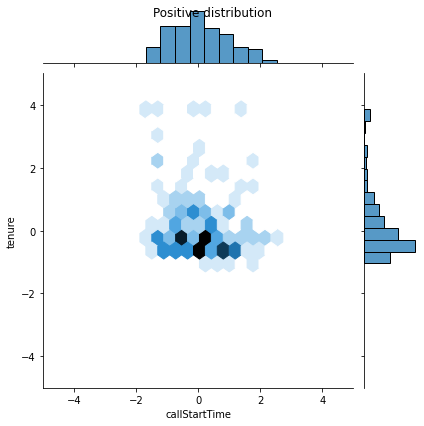

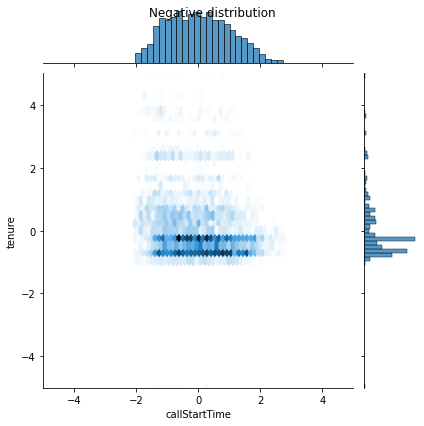

In [82]:
bool_train_labels = train_labels != 0
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)


sns.jointplot(pos_df['callStartTime'], pos_df['tenure'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['callStartTime'], neg_df['tenure'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
# normalize inputs
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

In [ ]:
X_train

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
# model.fit(
#     X_train,
#     y_train,
#     batch_size=BATCH_SIZE,
#     epochs=25,
#     validation_data=(X_test, y_test), 
#     verbose=0)
model.predict(train_features[:10])


In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
neg, pos = np.bincount(leads_df['isSale'])
initial_bias = np.log([pos/neg])
initial_bias

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
plot_metrics(baseline_history)


In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


In [ ]:
sale_av = 0
sale_c = 0
fail_av = 0
fail_c = 0

 

for i in range(len(test_predictions_baseline)):
    if y_test[i] == 0:
        fail_av += test_predictions_baseline[i]
        fail_c += 1
    else:
        sale_av += test_predictions_baseline[i]
        sale_c += 1
    print(test_predictions_baseline[i], y_test[i])
    
print(sale_av/sale_c, fail_av/fail_c)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')